# Access PROBA-V collection using openEO

PROBA-V was launched on May 6, 2013, to fill the gap in space-based vegetation measurements between SPOT-VGT (March 1998 – May 2014) and Sentinel-3. The mission objective of PROBA-V was to ensure continuity and consistency with the heritage of the SPOT-VGT mission.

Researchers can access Proba-V data globally through the openEO API. Leveraging the simplicity of openEO, users can utilize its scalability and interoperability features to conduct in-depth data analyses.

In this notebook, we will use the openEO platform to analyze the NDVI band from the Proba-V satellite product, enabling us to monitor vegetation health and changes over time.

In [3]:
# import the necessary packages

import openeo
import json
import pandas as pd
import plotly.express as px

In [4]:
# establish the connection and authenticate
connection = openeo.connect("openeofed.dataspace.copernicus.eu").authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=ZERS-HVGG 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


From a list of Proba-V collections, users can directly access the following 1-day, 5-day, and 10-day synthesis Proba-V data using openEO.

In [5]:
collections = connection.list_collections()

# Filter collections with "PROBA-V" in their title and print title and id
for collection in collections:
    if "title" in collection and "PROBA-V" in collection["title"]:
        print(f"ID: {collection.get('id')}, Title: {collection.get('title')}")

ID: PROBAV_L3_S10_TOC_333M, Title: PROBA-V S10 TOC 300 m COG: Decadal synthesis of S1's as Maximum Value Compositing (MVC), COG format - Collection 2
ID: PROBAV_L3_S5_TOC_100M, Title: PROBA-V S5 TOC 100 m COG: Data corrected for atmospheric effects with the SMAC (Simplified Method for Atmosheric Corrections) algorithm, COG format - Collection 2
ID: PROBAV_L3_S1_TOC_100M, Title: PROBA-V S1 TOC 100 m COG: Data corrected for atmospheric effects with the SMAC (Simplified Method for Atmosheric Corrections) algorithm, COG format - Collection 2
ID: PROBAV_L3_S1_TOC_333M, Title: PROBA-V S1 TOC 300 m COG: Data corrected for atmospheric effects with the SMAC (Simplified Method for Atmosheric Corrections) algorithm, COG format - Collection 2


Users can obtain detailed descriptions of each collection by executing the command `connection.describe_collection("PROBAV_L3_S10_TOC_333M")`. 

For this example, we will use the `PROBAV_L3_S5_TOC_100M` collection.


In [6]:
# Load data cube from PROBAV_L3_S5_TOC_100M collection.
cube = connection.load_collection(
    "PROBAV_L3_S5_TOC_100M",
    temporal_extent=["2021-03-01", "2021-06-01"],
    bands=["NDVI"],
)

In [7]:
# apply offset and rescale
cube = cube.apply(lambda x: 0.004 * x - 0.08)

Users can either download the NDVI data retrieved in the previous cell or proceed with further analysis. 

Here, we will create an NDVI time series. In the following cell, we will use the `DataCube.aggregate_spatial()` method to compute the mean NDVI for each specified field.

In [8]:
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field


fields = read_json("polygons.geojson")

In [9]:
ndvi_timeseries = cube.aggregate_spatial(geometries=fields, reducer="mean")

Finally, let us perform the computation synchronously and retrieve the results as a CSV file.

In [10]:
ndvi_timeseries.download("ProbaV_10days.csv")

In the following cell we will visualize the distribution of NDVI (Normalized Difference Vegetation Index) values over time using a box plot. This plot helps in understanding how vegetation health evolves over time 

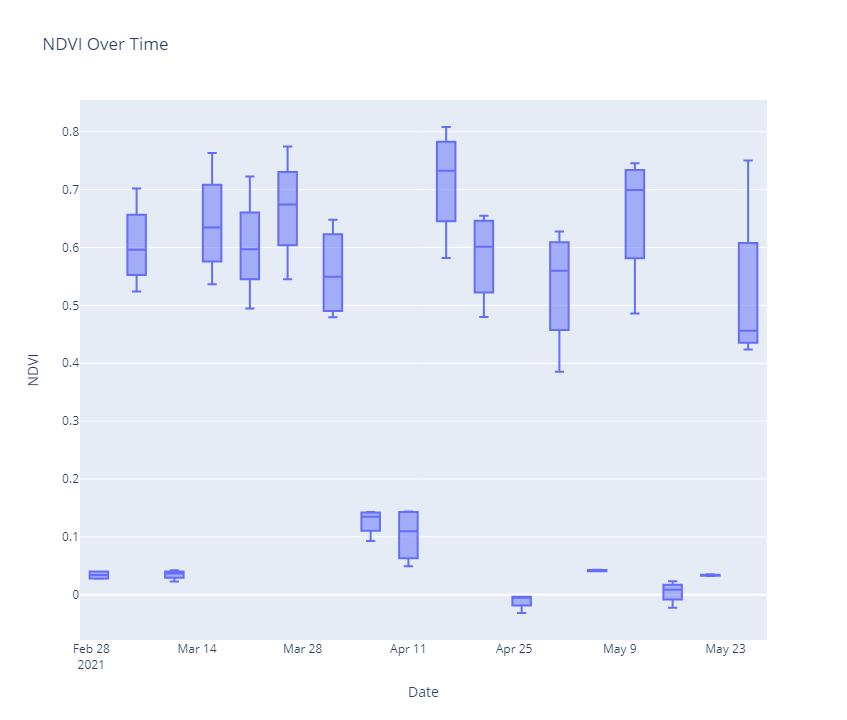

In [10]:
# Load the CSV file into a DataFrame
file_path = "ProbaV_10days.csv"
df = pd.read_csv(file_path)

# Create the box plot
px.box(
    df,
    x="date",
    y="NDVI",
    title="NDVI Over Time",
    labels={"date": "Date", "NDVI": "NDVI"},
)